# Import Libraries and Files

In [17]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix


from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import tree
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE

In [8]:
# Import test values

df_test = pd.read_csv('DrivenData Files/testsetvalues.csv')
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [9]:
df_test['year_recorded'] = pd.to_datetime(df_test['date_recorded']).dt.year
df_test['construction_year'] = df_test['construction_year'].replace({0:2012})
df_test['well_age'] = df_test['year_recorded'] - df_test['construction_year']
df_test['well_age'] = df_test['well_age'].replace({-1:0, -2:0, -4:0, -7:0, -8:0})
df_test.drop(columns = ['date_recorded', 'year_recorded', 'construction_year'], axis = 1, inplace = True)
print(df_test['well_age'].value_counts())


0     4855
1     1149
3      650
2      594
5      510
13     436
4      434
7      405
6      351
11     324
14     293
8      280
33     255
15     249
16     237
23     203
19     203
10     192
9      192
27     187
31     186
18     184
28     182
17     164
25     161
21     149
29     147
12     147
35     140
41     133
26     133
37     131
20     130
39     127
38      90
36      86
30      78
22      77
43      70
40      62
24      61
34      49
32      42
42      23
50      21
53      20
45      14
44      11
51       7
48       7
46       7
52       5
47       4
49       3
Name: well_age, dtype: int64


In [10]:
# Deal with null/missing values

df_test.drop(columns = ['scheme_name', 'subvillage', 'public_meeting'], axis = 1, inplace = True);
df_test['funder'].fillna('other', inplace = True)
df_test['installer'].fillna('other', inplace = True)
df_test['scheme_management'].fillna('other', inplace = True)
df_test['permit'].fillna('other', inplace = True)

In [11]:
# Drop columns that were determined to be dropped from training data

df_test.drop(columns = ['num_private', 'wpt_name', 'ward', 'recorded_by', 'permit', 
                       'management_group', 'payment_type', 'quality_group',
                       'quantity_group', 'source_type', 'source_class',
                       'waterpoint_type_group', 'extraction_type_group', 'extraction_type'], axis = 1, inplace = True)

## Organize Top 100 Values for Funder, Installer, and LGA

In [12]:
#Clean 'Funder' column and reduce values counts

def top_funders(var):
    if var in df_test['funder'].value_counts(normalize = True).head(100).index:
        return var
    else:
        return 'other'
    
df_test['top_funded'] = df_test['funder'].map(top_funders)

In [13]:
# Inspect changes to value counts

df_test['top_funded'].value_counts()

other                     3812
Government Of Tanzania    2215
Danida                     793
Hesawa                     580
World Bank                 352
                          ... 
Ru                          21
Germany                     21
Mdrdp                       21
Ndrdp                       20
Vwc                         20
Name: top_funded, Length: 100, dtype: int64

In [14]:
df_test['top_funded'].replace('Adb', 'other', inplace = True)
df_test['top_funded'].replace('Caritas', 'other', inplace = True)
df_test['top_funded'].replace('Ces(gmbh)', 'Ces (gmbh)', inplace = True)
df_test['top_funded'].replace('Co', 'Community', inplace = True)
df_test['top_funded'].replace('Concern', 'Concern World Wide', inplace = True)
df_test['top_funded'].replace('Dh', 'Dhv', inplace = True)
df_test['top_funded'].replace('Fin Water', 'Fini Water', inplace = True)
df_test['top_funded'].replace('FinW', 'Fini Water', inplace = True)
df_test['top_funded'].replace('Fw', 'Fini Water', inplace = True)
df_test['top_funded'].replace('Finw', 'Fini Water', inplace = True)
df_test['top_funded'].replace('Germany Republi', 'Germany', inplace = True)
df_test['top_funded'].replace('Go', 'Government Of Tanzania', inplace = True)
df_test['top_funded'].replace('He', 'Hesawa', inplace = True)
df_test['top_funded'].replace('Irish Ai', 'Ir', inplace = True)
df_test['top_funded'].replace('Is', 'Isf', inplace = True)
df_test['top_funded'].replace('Jica', 'Jaica', inplace = True)
df_test['top_funded'].replace('Ki', 'Kiliwater', inplace = True)
df_test['top_funded'].replace('Kibaha Town Council', 'other', inplace = True)
df_test['top_funded'].replace('Kkkt_makwale', 'Kkkt', inplace = True)
df_test['top_funded'].replace('Kuwait', 'other', inplace = True)
df_test['top_funded'].replace('Lwi', 'other', inplace = True)
df_test['top_funded'].replace('Ndrdp', 'Mdrdp', inplace = True)
df_test['top_funded'].replace('Nethalan', 'Netherlands', inplace = True)
df_test['top_funded'].replace('No', 'Norad', inplace = True)
df_test['top_funded'].replace('Oxfam', 'Oxfarm', inplace = True)
df_test['top_funded'].replace('Private', 'Private Individual', inplace = True)
df_test['top_funded'].replace('Rc', 'Roman Catholic', inplace = True)
df_test['top_funded'].replace('Rc Ch', 'Roman Catholic', inplace = True)
df_test['top_funded'].replace('Rc Church', 'Roman Catholic', inplace = True)
df_test['top_funded'].replace('Roman', 'Roman Catholic', inplace = True)
df_test['top_funded'].replace('Ru', 'Rudep', inplace = True)
df_test['top_funded'].replace('Tasaf', 'Tassaf', inplace = True)
df_test['top_funded'].replace('Unice', 'Unicef', inplace = True)
df_test['top_funded'].replace('Vwc', 'other', inplace = True)
df_test['top_funded'].replace('Water', 'Wateraid', inplace = True)

In [15]:
# Clean 'Installer' column and reduce value counts

def top_installer(var):
    if var in df_test['installer'].value_counts(normalize = True).head(100).index:
        return var
    else:
        return 'other'
    
df_test['top_installers'] = df_test['installer'].map(top_installer)

In [16]:
# Inspect changes to value counts

df_test['top_installers'].value_counts()

DWE            4349
other          3892
Government      457
RWE             292
Commu           287
               ... 
DAWASCO          23
FIN WATER        23
Shipo            22
Water board      21
Angli            21
Name: top_installers, Length: 100, dtype: int64

In [34]:
df_test['top_installers'].replace('ACRA', 'other', inplace = True)
df_test['top_installers'].replace('AICT', 'other', inplace = True)
df_test['top_installers'].replace('Adra', 'other', inplace = True)
df_test['top_installers'].replace('Amref', 'AMREF', inplace = True)
df_test['top_installers'].replace('CEFA', 'other', inplace = True)
df_test['top_installers'].replace('Centr', 'Central Government', inplace = True)
df_test['top_installers'].replace('Central government', 'Central Government', inplace = True)
df_test['top_installers'].replace('Central govt', 'Central Government', inplace = True)
df_test['top_installers'].replace('Commu', 'Community', inplace = True)
df_test['top_installers'].replace('DA', 'DANIDA', inplace = True)
df_test['top_installers'].replace('DANID', 'DANIDA', inplace = True)
df_test['top_installers'].replace('DAWASCO', 'other', inplace = True)
df_test['top_installers'].replace('Da', 'DANIDA', inplace = True)
df_test['top_installers'].replace('Danid', 'DANIDA', inplace = True)
df_test['top_installers'].replace('Distri', 'District Council', inplace = True)
df_test['top_installers'].replace('District council', 'District Council', inplace = True)
df_test['top_installers'].replace('FIN WATER', 'Fini Water', inplace = True)
df_test['top_installers'].replace('FW', 'Fini Water', inplace = True)
df_test['top_installers'].replace('FinW', 'Fini Water', inplace = True)
df_test['top_installers'].replace('Fini water', 'Fini Water', inplace = True)
df_test['top_installers'].replace('GOVER', 'Government', inplace = True)
df_test['top_installers'].replace('Gove', 'Government', inplace = True)
df_test['top_installers'].replace('Gover', 'Government', inplace = True)
df_test['top_installers'].replace('HE', 'Hesawa', inplace = True)
df_test['top_installers'].replace('HESAWA', 'Hesawa', inplace = True)
df_test['top_installers'].replace('JAICA', 'Jaica', inplace = True)
df_test['top_installers'].replace('JICA', 'Jaica', inplace = True)
df_test['top_installers'].replace('KKKT _ Konde and DWE', 'KKKT', inplace = True)
df_test['top_installers'].replace('Ki', 'Kiliwater', inplace = True)
df_test['top_installers'].replace('Lawatefuka water sup', 'Lawatefuka Water Supply', inplace = True)
df_test['top_installers'].replace('LWI', 'other', inplace = True)
df_test['top_installers'].replace('Magadini-Makiwaru wa', 'Magadini-Makiwaru Water Supply', inplace = True)
df_test['top_installers'].replace('NORAD', 'Norad', inplace = True)
df_test['top_installers'].replace('OXFAM', 'OXFARM', inplace = True)
df_test['top_installers'].replace('Priva', 'Private', inplace = True)
df_test['top_installers'].replace('RC', 'RC CHURCH', inplace = True)
df_test['top_installers'].replace('Roman', 'RC CHURCH', inplace = True)
df_test['top_installers'].replace('SHIPO', 'Shipo', inplace = True)
df_test['top_installers'].replace('World', 'World Bank', inplace = True)
df_test['top_installers'].replace('World vision', 'World Vision', inplace = True)
df_test['top_installers'].replace('Water board', 'other', inplace = True)

In [18]:
# Clean 'lga' column and reduce value counts

def top_lgas(var):
    if var in df_test['lga'].value_counts(normalize = True).head(100).index:
        return var
    else:
        return 'other'
    
df_test['top_lga'] = df_test['lga'].map(top_lgas)

In [19]:
# Inspect changes to value counts

df_test['top_lga'].value_counts()

other          812
Njombe         625
Moshi Rural    315
Bariadi        308
Kasulu         275
              ... 
Ruangwa         57
Tarime          55
Nanyumbu        55
Bahi            55
Chato           52
Name: top_lga, Length: 101, dtype: int64

In [20]:
df_test['top_lga'].replace('Kiteto', 'other', inplace = True)
df_test['top_lga'].replace('Nanyumbu', 'other', inplace = True)
df_test['top_lga'].replace('Tarime', 'other', inplace = True)

## Preprocess Remaining Data

In [35]:
# Drop id because it is unnecessary, drop funder and installer because new features were added with their clean data.

df_test.drop(columns = ['id', 'funder', 'installer', 'lga'], axis = 1, inplace = True)

KeyError: "['id' 'funder' 'installer' 'lga'] not found in axis"

In [22]:
# Change data type of district_code and region_code to 'string' in order to be one-hot encoded

df_test['district_code'] = df_test['district_code'].astype('str')
df_test['region_code'] = df_test['region_code'].astype('str')

In [23]:
# Inspect remaining columns for any null values. 

df_test.isnull().sum()

amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
population               0
scheme_management        0
extraction_type_class    0
management               0
payment                  0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
well_age                 0
top_funded               0
top_installers           0
top_lga                  0
dtype: int64

# Model Preparation

In [36]:
# Isolate continuous variables 

test_cont = df_test[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'well_age']]

In [37]:
# Isolate categorical variables 

test_cat = df_test.drop(columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
                                        'well_age'], axis = 1)

In [38]:
# One-hot encode categorical variables using pd.get_dummies

test_dummies = pd.get_dummies(test_cat, drop_first = True)
test_dummies.head()

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,...,top_lga_Singida Rural,top_lga_Songea Rural,top_lga_Sumbawanga Rural,top_lga_Tandahimba,top_lga_Tunduru,top_lga_Ukerewe,top_lga_Ulanga,top_lga_Urambo,top_lga_Uyui,top_lga_other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Concatenate the OHE categorical and continuous variables back together 

processed_test = pd.concat([test_dummies, test_cont], axis = 1)
processed_test.head()

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,...,top_lga_Ulanga,top_lga_Urambo,top_lga_Uyui,top_lga_other,amount_tsh,gps_height,longitude,latitude,population,well_age
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1996,35.290799,-4.059696,321,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.0,1569,36.656709,-3.309214,300,13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1567,34.767863,-5.004344,500,3
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0.0,267,38.058046,-9.418672,250,26
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,500.0,1260,35.006123,-10.950412,60,13


In [41]:
# Save file for direct import

processed_test.to_csv('top100train', index = False)

In [3]:
processed_test = pd.read_csv('Saved Files/top100train')
processed_test.head()

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,...,top_lga_Ulanga,top_lga_Urambo,top_lga_Uyui,top_lga_other,amount_tsh,gps_height,longitude,latitude,population,well_age
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1996,35.290799,-4.059696,321,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.0,1569,36.656709,-3.309214,300,13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1567,34.767863,-5.004344,500,3
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0.0,267,38.058046,-9.418672,250,26
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,500.0,1260,35.006123,-10.950412,60,13


# Import and Process Training Data

In [4]:
# Import training data 

df_train = pd.read_csv('Saved Files/experimental100_training_set')
df_train.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,scheme_management,...,payment,water_quality,quantity,source,waterpoint_type,well_age,status_group,top_funded,top_installers,top_lga
0,6000.0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,109,VWC,...,pay annually,soft,enough,spring,communal standpipe,12,functional,Roman Catholic,RC CHURCH,Ludewa
1,0.0,1399,34.698766,-2.147466,Lake Victoria,Mara,20,2,280,Other,...,never pay,soft,insufficient,rainwater harvesting,communal standpipe,3,functional,other,other,Serengeti
2,25.0,686,37.460664,-3.821329,Pangani,Manyara,21,4,250,VWC,...,pay per bucket,soft,enough,dam,communal standpipe multiple,4,functional,other,World Vision,Simanjiro
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,58,VWC,...,never pay,soft,dry,machine dbh,communal standpipe multiple,27,non functional,Unicef,UNICEF,other
4,0.0,0,31.130847,-1.825359,Lake Victoria,Kagera,18,1,0,other,...,never pay,soft,seasonal,rainwater harvesting,communal standpipe,12,functional,other,Artisan,Karagwe


In [5]:
df_train['district_code'] = df_train['district_code'].astype('str')
df_train['region_code'] = df_train['region_code'].astype('str')

# Split Continuous and Categorical Variables, OHE Categorical Variables

train_cont = df_train[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'well_age']]

train_cat = df_train.drop(columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
                                        'well_age', 'status_group'], axis = 1)

train_dummies = pd.get_dummies(train_cat, drop_first = True)

processed_train = pd.concat([train_dummies, train_cont], axis = 1)
processed_train.head()

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,...,top_lga_Ulanga,top_lga_Urambo,top_lga_Uyui,top_lga_other,amount_tsh,gps_height,longitude,latitude,population,well_age
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6000.0,1390,34.938093,-9.856322,109,12
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0.0,1399,34.698766,-2.147466,280,3
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,25.0,686,37.460664,-3.821329,250,4
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0.0,263,38.486161,-11.155298,58,27
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0.0,0,31.130847,-1.825359,0,12


In [6]:
set(processed_test.columns).difference(processed_train.columns)

set()

In [7]:
set(processed_train.columns).difference(processed_test.columns)

set()

In [40]:
for col in processed_train.columns:
    print(col)

basin_Lake Nyasa
basin_Lake Rukwa
basin_Lake Tanganyika
basin_Lake Victoria
basin_Pangani
basin_Rufiji
basin_Ruvuma / Southern Coast
basin_Wami / Ruvu
region_Dar es Salaam
region_Dodoma
region_Iringa
region_Kagera
region_Kigoma
region_Kilimanjaro
region_Lindi
region_Manyara
region_Mara
region_Mbeya
region_Morogoro
region_Mtwara
region_Mwanza
region_Pwani
region_Rukwa
region_Ruvuma
region_Shinyanga
region_Singida
region_Tabora
region_Tanga
region_code_10
region_code_11
region_code_12
region_code_13
region_code_14
region_code_15
region_code_16
region_code_17
region_code_18
region_code_19
region_code_2
region_code_20
region_code_21
region_code_24
region_code_3
region_code_4
region_code_40
region_code_5
region_code_6
region_code_60
region_code_7
region_code_8
region_code_80
region_code_9
region_code_90
region_code_99
district_code_1
district_code_13
district_code_2
district_code_23
district_code_3
district_code_30
district_code_33
district_code_4
district_code_43
district_code_5
district_c

In [41]:
for col in processed_test.columns:
    print(col)

basin_Lake Nyasa
basin_Lake Rukwa
basin_Lake Tanganyika
basin_Lake Victoria
basin_Pangani
basin_Rufiji
basin_Ruvuma / Southern Coast
basin_Wami / Ruvu
region_Dar es Salaam
region_Dodoma
region_Iringa
region_Kagera
region_Kigoma
region_Kilimanjaro
region_Lindi
region_Manyara
region_Mara
region_Mbeya
region_Morogoro
region_Mtwara
region_Mwanza
region_Pwani
region_Rukwa
region_Ruvuma
region_Shinyanga
region_Singida
region_Tabora
region_Tanga
region_code_10
region_code_11
region_code_12
region_code_13
region_code_14
region_code_15
region_code_16
region_code_17
region_code_18
region_code_19
region_code_2
region_code_20
region_code_21
region_code_24
region_code_3
region_code_4
region_code_5
region_code_6
region_code_60
region_code_7
region_code_8
region_code_80
region_code_9
region_code_90
region_code_99
district_code_1
district_code_13
district_code_2
district_code_23
district_code_3
district_code_30
district_code_33
district_code_4
district_code_43
district_code_5
district_code_53
district

# Modeling

In [8]:
# Split data into target (y) and predictors (X)

X = processed_train
y = df_train['status_group']

In [9]:
# Scale training data to make sure that all of our data is represented at the same scale
scale = MinMaxScaler()

# Fit
X_train = scale.fit_transform(X) 
X_test = scale.transform(processed_test) 

In [10]:
print(X_train.shape)
print(X_test.shape)

(59400, 360)
(14850, 360)


### Classifier 1

In [51]:
# Instantiate XGBClassifier
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

# Fit Non MinMaxScaled XGBClassifier
clf.fit(X, y)

/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:07:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [52]:
# Predict on training and test sets

test_preds = clf.predict(processed_test)

In [53]:
# Accuracy of training and test sets for classifier 1

training_accuracy = clf.score(X, y)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))

# 250 Estimators: 88.10%
# 400 Estimators: 90.92%

Training Accuracy: 90.92%


### Classifier 2: MinMax Scaled

In [11]:
# Instantiate XGBClassifier
clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

# Fit MinMax Scaled XGBClassifier
clf2.fit(X_train, y)

/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:55:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [12]:
# Predict on training and test sets with classifier 2

test_preds2 = clf2.predict(X_test)

In [13]:
# Accuracy of training and test sets for classifier 2

training_accuracy = clf2.score(X_train, y)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))

# 250 Estimators: 88.05%
# 400 Estimators: 90.94%

Training Accuracy: 90.94%


<Figure size 1080x576 with 0 Axes>

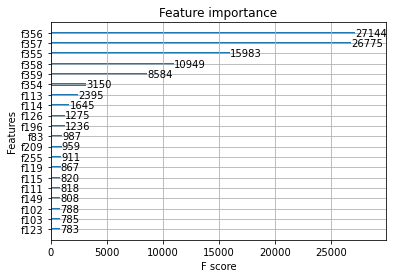

In [23]:
# Assess feature importances

plt.figure(figsize = (15,8))
plot_importance(clf2, max_num_features= 20)
plt.show();

## Import and Process Submission File

In [55]:
# Import submission format file

model_submit = pd.read_csv('DrivenData Files/SubmissionFormat.csv')
model_submit.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


In [56]:
model_submit.drop(['status_group'], axis = 1, inplace = True)
model_submit.head()

,id
0,50785
1,51630
2,17168
3,45559
4,49871


### Classifier 1

In [57]:
# Format the test predictions into a pandas dataframe

test_pred_df = pd.DataFrame(data = test_preds)

# Name the outcome label column

test_pred_df = test_pred_df.rename(columns = {0: 'status_group'})

# Concatenate the test labels and submission format file

test_pred_df = pd.concat([model_submit, test_pred_df], axis = 1)

In [58]:
test_pred_df['status_group'] = test_pred_df['status_group'].astype(str)

In [59]:
# Convert the outcome column 'status_group' into numeric values

test_pred_df['status_group'].replace('1', 'functional', inplace = True)
test_pred_df['status_group'].replace('0', 'non_functional', inplace = True)
test_pred_df['status_group'].replace('2', 'functional_needs_repair', inplace = True)

In [60]:
test_pred_df['status_group'].value_counts()

functional                 9568
non functional             4909
functional needs repair     373
Name: status_group, dtype: int64

### Classifier 2

In [66]:
# Format the test predictions into a pandas dataframe

test_pred_df2 = pd.DataFrame(data = test_preds2)

# Name the outcome label column

test_pred_df2 = test_pred_df2.rename(columns = {0: 'status_group'})

# Concatenate the test labels and submission format file

test_pred_df2 = pd.concat([model_submit, test_pred_df2], axis = 1)

In [67]:
test_pred_df2['status_group'] = test_pred_df2['status_group'].astype(str)

In [68]:
# Convert the outcome column 'status_group' into numeric values

test_pred_df2['status_group'].replace('1', 'functional', inplace = True)
test_pred_df2['status_group'].replace('0', 'non_functional', inplace = True)
test_pred_df2['status_group'].replace('2', 'functional_needs_repair', inplace = True)

In [69]:
test_pred_df2['status_group'].value_counts()

functional                 9584
non functional             4873
functional needs repair     393
Name: status_group, dtype: int64

## Save File for Submission

In [88]:
# Non - MinMaxScaled Top 100 Model, Classifier 1: Score = 0.8061

#test_pred_df.to_csv('test_set_predictions_9', index = False)

In [89]:
# MinMaxScaled Top 100 Model, Classifier 2: Score = 0.8045

#test_pred_df2.to_csv('test_set_predictions_10', index = False)

In [61]:
# Non - MinMaxScaled Top 100 Model, 400 Estimators: Score = 0.8076

#test_pred_df.to_csv('test_set_predictions_22', index = False)

In [70]:
# MinMaxScaled Top 100 Model, 400 Estimators: Score = 0.8093

#test_pred_df2.to_csv('test_set_predictions_23', index = False)